<h1 align='center'>Dropout as Regularization and Bayesian Approximation</h1>

 <h3 align='center'>Weidong Xu, Zeyu Zhao, Tianning Zhao</h3>

Our assigned paper is [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/pdf/1207.0580.pdf). In our tutorial, we also implemented models in the paper [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/pdf/1506.02142.pdf) to show that dropout can provide model uncertainty.

**This tutorial aims to give readers a complete view of dropout, which includes the implementation of dropout, how to use dropout and why dropout is useful. Basically, dropout can (1) reduce overfitting (so test results will be better) and (2) provide model uncertainty like Bayesian models we see in the class (Bayesian Approximation).**

**Warning: Training deep neural networks is very computational intensive so we provide all trained models for this notebook and commented out all training code. If readers want to train the models themselves, we suggest using GPU.**

## 1. Introduction
Deep neural network is a very powerful tool in machine learning. Multiple non-linear hidden layers enable the model to learn complicated relationships between input and output. However, when the training set is small, there are different parameter settings that would fits training set perfectly, but the one complex parameter setting tends to perform poorly on the test dataset, ie we got the problem of overfitting. One way to solve this problem is by averaging predictions of different neural networks , but this becomes computationally expensive when applied to large datasets. The alternative that makes it possible to train a huge number of different networks in a reasonable time is dropout, which randomly omits some hidden units i.e. feature detectors to prevent co-adaption. The idea of dropout model can be shown as below.

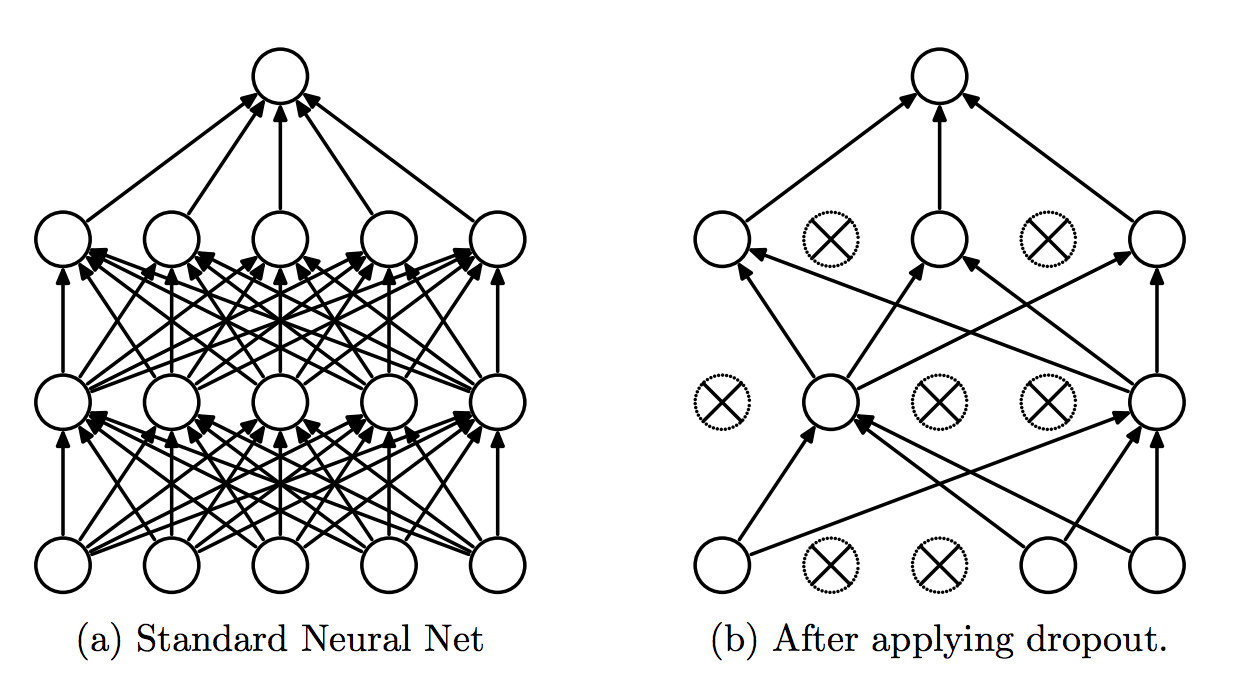

ref: Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A simple way to prevent neural networks from overfitting. The Journal of Machine Learning Research, 15(1), 1929-1958.

## 2. Model Description
With dropout, the feed-forward operation of neural networks can be described as :

$$r_j^{(l)} \sim Bernoulli(p),$$
$$\tilde y^{(l)} = r^{(l)} \times y^{(l)},$$
$$z_i^{(l+1)} = w_i^{(l+1)}\tilde y^{(l)} + b_i^{(l+1)},$$
$$y_i^{(l+1)} = f(z_i^{(l+1)})$$

where $l$ is the index the hidden layers of the network, $z^{(l)}$ denote
the vector of inputs into layer $l$, $y^{(l)}$ denote the vector of outputs from layer $l$ ($y^{(0)} = x$ is the input). $w^{(l)}$ and $b^{(l)}$ are the weights and biases at layer $l$. f is any activation function.

With this, the standard stochastic gradient descent procedure was used for training the dropout neural networks on mini-batches of training cases.  

For testing, we use the “mean network” that contains all of the hidden units with their outgoing weights halved instead of averaging over a large number of dropout networks.

## 3. Dropout Implementation

All our implementations are based on PyTorch. The model training is on GPU and all other tasks are on CPU (so readers with no GPUs can run our notebook). To switch between GPU and CPU, you can add or remove `.cuda()` in the code.

### Import libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

### Dropout Implementation

Below is the dropout layer we implemented, based on PyTorch.

We should multiply the dropout output by $\frac{1}{1-p}$ where $p$ is the dropout rate to compensate for the dropped neurons. We implemented a dropout layer below, it should have same functionality as `nn.Dropout` in Pytorch.

We will use `MyDropout` in our first example network to show the implementation works. However, since `nn.Dropout` is more efficient than our implementation, we will use `nn.Dropout` for all remaining networks.

In [3]:
class MyDropout(nn.Module):
    def __init__(self, p=0.5):
        super(MyDropout, self).__init__()
        self.p = p
        # multiplier is 1/(1-p). Set multiplier to 0 when p=1 to avoid error...
        if self.p < 1:
            self.multiplier_ = 1.0 / (1.0-p)
        else:
            self.multiplier_ = 0.0
    def forward(self, input):
        # if model.eval(), don't apply dropout
        if not self.training:
            return input
        
        # So that we have `input.shape` numbers of Bernoulli(1-p) samples
        selected_ = torch.Tensor(input.shape).uniform_(0,1)>self.p
        
        # To support both CPU and GPU.
        if input.is_cuda:
            selected_ = Variable(selected_.type(torch.cuda.FloatTensor), requires_grad=False)
        else:
            selected_ = Variable(selected_.type(torch.FloatTensor), requires_grad=False)
            
        # Multiply output by multiplier as described in the paper [1]
        return torch.mul(selected_,input) * self.multiplier_

## 4. Dropout as Regularization

In this section, we want to show dropout is a kind of regularization techniques for deep neural networks. It can reduce the overfitting and make our network perform better on test set. We will first do a multilayer perceptron (fully connected network) to show dropout works and then do a LeNet (convolutional neural network) to show dropout is also useful for different network architectures.

We use MNIST (as we see in homework) as our sample dataset. This dataset has images of hand written digits and the labels of the ground truth digits. Code cell below loads the dataset and shows 10 training samples.

Processing...
Done!


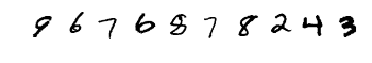

label: [9 6 7 6 8 7 8 2 4 3]
image data shape: (1, 28, 28)


In [5]:
transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize((0, 0, 0), (1, 1, 1))])

trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

# Visualize 10 image samples in MNIST dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
dataiter = iter(trainloader)
images, labels = dataiter.next()
# plot 10 sample images
_,ax = plt.subplots(1,10)
ax = ax.flatten()
iml = images[0].numpy().shape[1]
[ax[i].imshow(np.transpose(images[i].numpy(),(1,2,0)).reshape(iml,-1),cmap='Greys') for i in range(10)]
[ax[i].set_axis_off() for i in range(10)]
plt.show()
print('label:',labels[:10].numpy())
print('image data shape:',images[0].numpy().shape)

### 4.1 Multilayer Perceptron

We first build a multilayer perceptron (MLP), and use the code below to define the network as described in paper [1]. This network has 1 hidden layer with 800 hidden units.

In [7]:
class MLP(nn.Module):
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0]):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module("dropout0",MyDropout(p=droprates[0]))
        self.model.add_module("input", nn.Linear(28*28, hidden_layers[0]))
        self.model.add_module("tanh", nn.Tanh())
        
        # Add hidden layers
        for i,d in enumerate(hidden_layers[:-1]):
            self.model.add_module("dropout_hidden"+str(i+1), MyDropout(p=droprates[1]))
            self.model.add_module("hidden"+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.model.add_module("tanh_hidden"+str(i+1), nn.Tanh())
        self.model.add_module("final",nn.Linear(hidden_layers[-1], 10))        
        
    def forward(self, x):
        # Turn to 1D
        x = x.view(x.shape[0], 28*28)
        x = self.model(x)
        return x

Next, we implement a sklearn-like classifier for training and keep track of the **full test results** after each epoch.

In [8]:
class MLPClassifier:
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0], batch_size=128, max_epoch=10, \
                 lr=0.1, momentum=0):
        # Wrap MLP model
        self.hidden_layers = hidden_layers
        self.droprates = droprates
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = MLP(hidden_layers=hidden_layers, droprates=droprates)
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)
        self.loss_ = []
        self.test_accuracy = []
        self.test_error = []
        
    def fit(self, trainset, testset, verbose=True):
        # Training, make sure it's on GPU, otherwise, very slow...
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test.cuda()
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
            self.loss_.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
            y_test_pred = self.predict(X_test).cpu()
            self.test_accuracy.append(np.mean(y_test == y_test_pred))
            self.test_error.append(int(len(testset)*(1-self.test_accuracy[-1])))
            if verbose:
                print('Test error: {}; test accuracy: {}'.format(self.test_error[-1], self.test_accuracy[-1]))
        return self
    
    def predict(self, x):
        # Used to keep all test errors after each epoch
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred
    
    def __str__(self):
        return 'Hidden layers: {}; dropout rates: {}'.format(self.hidden_layers, self.droprates)

Paper [1] tried three networks. One with **no dropout**, one with **dropout in hidden layers** and one with **dropout in both hidden layers and input**. We use the same number of epoches, the same dropout rate as in paper [1]. We define those three networks in the code section below.

In [12]:
hidden_layers = [800, 800]

### Below is training code, uncomment to train your own model... ###
### Note: You need GPU to run this section ###
'''
# Define networks
mlp1 = [MLPClassifier(hidden_layers, droprates=[0, 0], max_epoch=3000), 
        MLPClassifier(hidden_layers, droprates=[0, 0.5], max_epoch=3000),
        MLPClassifier(hidden_layers, droprates=[0.2, 0.5], max_epoch=3000)]
        
# Training, set verbose=True to see loss after each epoch.
[mlp.fit(trainset, testset,verbose=False) for mlp in mlp1]

# Save torch models
for ind, mlp in mlp1:
    torch.save(mlp.model, 'mnist_mlp1_'+str(ind)+'.h5')
    # Prepare to save errors
    mlp.test_error = list(map(str, mlp.test_error))

# Save test errors to plot figures
open("mlp1_test_errors.txt","w").write('\n'.join([','.join(mlp.test_error)] for mlp in mlp1)) 
'''

# Load saved models to CPU
mlp1_models = [torch.load('mnist_mlp1_'+str(ind)+'.h5',map_location={'cuda:0': 'cpu'}) for ind in [0,1,2]]

# Load saved test errors to plot figures.
mlp1_test_errors = [error_array.split(',') for error_array in open("mlp1_test_errors.txt","r").read().split('\n')]
mlp1_test_errors = np.array(mlp1_test_errors,dtype='f')

After the training, we can plot the number of error predictions on test set after each epoch for all three networks as in paper [1].

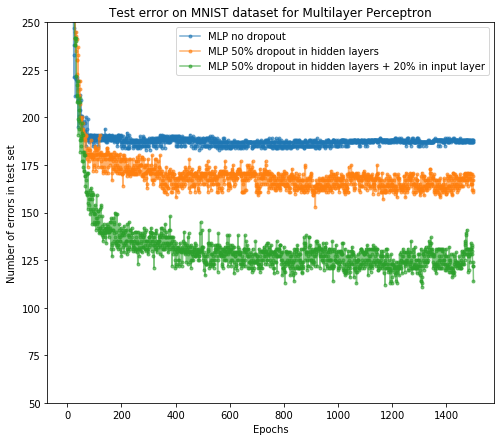

In [17]:
labels = ['MLP no dropout', 
          'MLP 50% dropout in hidden layers', 
          'MLP 50% dropout in hidden layers + 20% in input layer']

plt.figure(figsize=(8, 7))
for i, r in enumerate(mlp1_test_errors):
    plt.plot(range(1, len(r)+1), r, '.-', label=labels[i], alpha=0.6);
plt.ylim([50, 250]);
plt.legend(loc=1);
plt.xlabel('Epochs');
plt.ylabel('Number of errors in test set');
plt.title('Test error on MNIST dataset for Multilayer Perceptron')
plt.show()

From the result, we see dropout as regularization is useful and it successfully improves the network accuracy on the test set. In addition, further adding the dropout layer after the input layer will help as well.

### 4.2 Convolutional Neural Network (LeNet)

Next, we show dropout can improve test performance in convolutional neural networks as well. Here, we implement a simple LeNet for demonstration. The LeNet architecture is shown below.

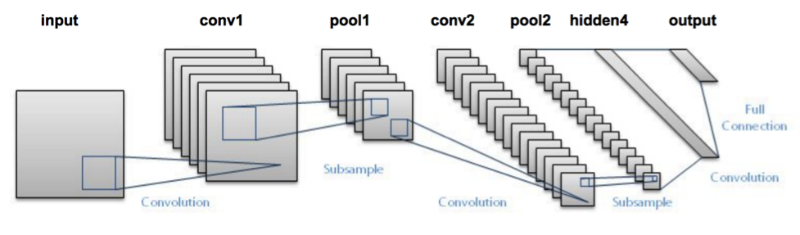

ref: https://blog.dataiku.com/deep-learning-with-dss

We first calculate the dimension of images after going through convolutional layers and pooling layers since we need to specify in and out dimensions for linear layers in `pytorch`.

In [10]:
def caloutdim(hin, kernel_size, stride=1, padding=0, dilation=1):
    return int(np.floor((hin+2*padding-dilation*(kernel_size-1)-1)/stride+1))

d = [28]
d.append(caloutdim(d[-1], 5, padding=2))
d.append(caloutdim(d[-1], 2, 2))
d.append(caloutdim(d[-1], 5, padding=2))
d.append(caloutdim(d[-1], 2, 2))
print(d)

[28, 28, 14, 14, 7]


The code cell below defines the LeNet.

In [18]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

class LeNet(nn.Module):
    def __init__(self, droprate=0.5):
        super(LeNet, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('conv1', nn.Conv2d(1, 20, kernel_size=5, padding=2))
        self.model.add_module('dropout1', nn.Dropout2d(p=droprate))
        self.model.add_module('maxpool1', nn.MaxPool2d(2, stride=2))
        self.model.add_module('conv2', nn.Conv2d(20, 50, kernel_size=5, padding=2))
        self.model.add_module('dropout2', nn.Dropout2d(p=droprate))
        self.model.add_module('maxpool2', nn.MaxPool2d(2, stride=2))
        self.model.add_module('flatten', Flatten())
        self.model.add_module('dense3', nn.Linear(50*7*7, 500))
        self.model.add_module('relu3', nn.ReLU())
        self.model.add_module('dropout3', nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(500, 10))
        
    def forward(self, x):
        return self.model(x)

Similar as above, we implement a sklearn-like classifier for LeNet.

In [19]:
class LeNetClassifier:
    def __init__(self, droprate=0.5, batch_size=128, max_epoch=300, lr=0.01):
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = LeNet(droprate)
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.loss_ = []
        self.test_error = []
        self.test_accuracy = []
        
    def fit(self, trainset, testset, verbose=True):
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test.cuda()
        print(self.model)
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
            self.loss_.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
            y_test_pred = self.predict(X_test).cpu()
            self.test_accuracy.append(np.mean(y_test == y_test_pred))
            self.test_error.append(int(len(testset)*(1-self.test_accuracy[-1])))
            if verbose:
                print('Test error: {}; test accuracy: {}'.format(self.test_error[-1], self.test_accuracy[-1]))
        return self
    
    def predict(self, x):
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred

And the training code is below. We load our trained models here.

In [29]:
### Below is training code, uncomment to train your own model... ###
### Note: You need GPU to run this section ###
'''
# Define networks
lenet1 = [LeNetClassifier(droprate=0, max_epoch=3),
          LeNetClassifier(droprate=0.5, max_epoch=3)]
        
# Training, set verbose=True to see loss after each epoch.
[lenet.fit(trainset, testset,verbose=False) for lenet in lenet1]

# Save torch models
for ind, lenet in lenet1:
    torch.save(lenet.model, 'mnist_lenet1_'+str(ind)+'.h5')
    # Prepare to save errors
    lenet.test_error = list(map(str, lenet.test_error))

# Save test errors to plot figures
open("lenet1_test_errors.txt","w").write('\n'.join([','.join(lenet.test_error)] for lenet in lenet1)) 
'''

# Load saved models to CPU
lenet1_models = [torch.load('mnist_lenet1_'+str(ind)+'.h5',map_location={'cuda:0': 'cpu'}) for ind in [0,1]]

# Load saved test errors to plot figures.
lenet1_test_errors = [error_array.split(',') for error_array in 
                      open("lenet1_test_errors.txt","r").read().split('\n')]
lenet1_test_errors = np.array(lenet1_test_errors,dtype='f')

After the training, we can plot the number of error predictions on test set after each epoch for all networks. Here we overlay the LeNet result on the MLP network we just showed.

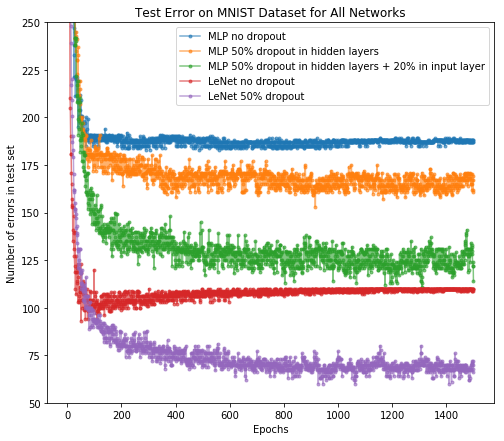

In [31]:
labels = ['MLP no dropout', 
          'MLP 50% dropout in hidden layers', 
          'MLP 50% dropout in hidden layers + 20% in input layer',
          'LeNet no dropout',
          'LeNet 50% dropout']

plt.figure(figsize=(8, 7))
for i, r in enumerate(mlp1_test_errors.tolist() + lenet1_test_errors.tolist()):
    plt.plot(range(1, len(r)+1), r, '.-', label=labels[i], alpha=0.6);
plt.ylim([50, 250]);
plt.legend(loc=1);
plt.xlabel('Epochs');
plt.ylabel('Number of errors in test set');
plt.title('Test Error on MNIST Dataset for All Networks')
plt.show()

As we can see, 
1. Dropout in hidden layers can reduce test errors in standard feedforward network (i.e., MLP); we can further improve the test performance by applying dropout in input layer.
2. LeNet performs better than MLP even without dropout, but overfitting occurs. Dropout significantly improves the test performance, which demonstrates dropout as an effective regularization method in CNNs.

## 4. Dropout as Bayesian Approximation
It is shown that deep NNs with dropout applied before every weight layer are mathematically equivalent to approximate variational inference in the deep Gaussian process marginalised over its covariance function parameters (Yarin Gal et al). 

The related Gaussian process could be described as below:

$$F \vert X, W_1, b \sim N(0, K(X,X))$$
$$Y \vert F \sim N(F, \tau^{-1}I_N)$$
Introduing $W_1$, which is a matrix parameterizing the covariance function K:
$$ p(Y\vert X) = \int p(Y\vert F)p(F\vert W_1, b, X)p(W_1)p(b)$$
Introduing $W_2$, another matrix that get the integration rid of F:
$$ p(Y\vert X) = \int p(Y\vert X, W_1, W_2, b)p(W_1)p(W_2)p(b)$$
To perform variational inference in our approximate model we need to define a variational distribution $q(W_1, W_2, b) := q(W_1)q(W_2)q(b)$, where $q(W_1)$ and $q(W_2)$ are defined as a Gaussian mixture model with two components, factorized over dimensinality of $W_1$ and $W_2$. For example: 

$$q(W_1) = \prod_{q=1}^{Q}q(w_q) $$
$$ q(w_q) = p_1N(m_q, \sigma^2I_K) + (1-p_1)N(0,\sigma^2I_K)$$

with some probability p1 ∈ [0, 1], scalar σ > 0 and $m_q ∈ R^K $

In dropout model, the input was weighted by some weight matrix and then pass into some non-linear function, which is the same as what we did with the parameterizing matrix and covariance function. The output of the non-linear function would be the input of the next hidden layer. When we implement dropout, we actually created a binary vector to decide which hidden unit would be passed to the next layer, which is similar to what we did for the variational inference. With this setup, we update the parameters by minimizing some loss function we choose, just as minimizing KL divergence in Gaussian process approximation.


### 4.1. Dropout as Bayesian Approximation in Classification Task

Here we use the models (MLP and LeNet) that we trained above for the classification of MNIST digits to demonstrate how we can acquire model uncertainty through dropout.

We evaluate the models on a continuously rotated image of the digit 1 (as shown below).

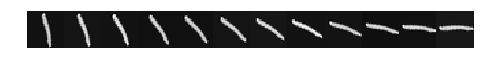

In [17]:
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
X_test, y_test = iter(testloader).next()
X_test = X_test.numpy()
X1 = np.array([rotate(X_test[9978].squeeze(), i, reshape=False) for i in range(50, 130, 7)])
X1 = X1.reshape(X1.shape[0], 1, X1.shape[1], X1.shape[2])

plt.figure(figsize=(8, 1))

gs = gridspec.GridSpec(1, 12)
gs.update(wspace=0, hspace=0)

for i in range(len(X1)):
    plt.subplot(gs[i])
    plt.imshow(X1.squeeze()[i], cmap='gray');
    plt.axis('off');

For each model, we simulate 1000 stochastic forward passes, and visualize distributions of the softmax inputs and the softmax outputs for each of the top classes.

In [18]:
def predict_class(model, X):
    model = model.eval()
    outputs = model(Variable(X.cuda()))
    _, pred = torch.max(outputs.data, 1)
    model = model.train()
    return pred.cpu().numpy()

def predict(model, X, T=1000):
    standard_pred = predict_class(model, X)
    y1 = []
    y2 = []
    for _ in range(T):
        _y1 = model(Variable(X.cuda())).cpu()
        _y2 = F.softmax(_y1, dim=1)
        y1.append(_y1.data.numpy())
        y2.append(_y2.data.numpy())
    return standard_pred, np.array(y1), np.array(y2)

#### MLP 50% dropout in hidden layers + 20% in input layer

In [25]:
model = IO('results/mnist_mlp1_2.pkl').read_pickle()
y1_pred, y1_si, y1_so = predict(model, torch.from_numpy(X1))
print('Predictions: {}'.format(y1_pred))

Predictions: [1 1 1 1 1 3 3 7 7 7 7 7]


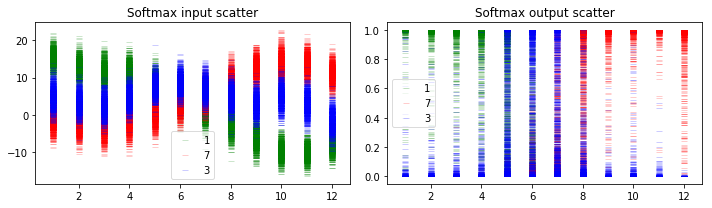

In [26]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax output scatter');
plt.legend(framealpha=0.7);

plt.tight_layout();

#### LeNet 50% dropout

In [27]:
model = IO('results/mnist_lenet1_1.pkl').read_pickle()
y1_pred, y1_si, y1_so = predict(model, torch.from_numpy(X1))
print('Predictions: {}'.format(y1_pred))

Predictions: [1 1 1 1 1 1 7 7 7 7 7 7]


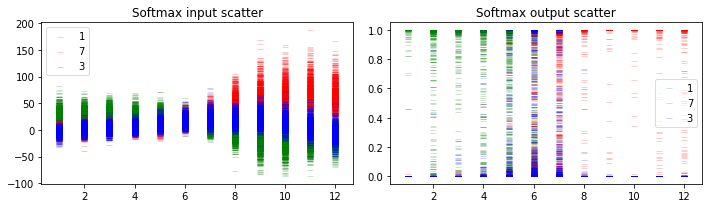

In [28]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax output scatter');
plt.legend(framealpha=0.7);

plt.tight_layout();

When the uncertainty envelop of the top class is far away from that of other classes (e.g., the leftmost image), we can make predictions with high confidence. When the uncertainty envelopes for different classes intersect with each other (e.g., the middle input images), the softmax output can be as large as the entire space even though the softmax output can be arbitrarily high.

Although we got different predictions for the middle images, the softmax output scatters show that we make those predictions with high uncertainty. And the softmax output scatters for 2 different networks look similar, although the softmax input scatters look sightly different.

As mentioned by the authors, such uncertainty information can help us obtain higher classification accuracies (not shown in this paper), and help us check whether we correctly specify the model or whether we have enough data.

### 4.2. Dropout as Bayesian Approximation in Regression Task

In this part, we show how to use dropout to obtain model uncertainty in regression tasks.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py

import pymc3 as pm

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pickle

class IO:
    def __init__(self, file_name):
        self.file_name = file_name
        
    def to_pickle(self, obj):
        with open(self.file_name, 'wb') as output:
            pickle.dump(obj, output, protocol=pickle.HIGHEST_PROTOCOL)
    
    def read_pickle(self):
        with open(self.file_name, 'rb') as input_:
            obj = pickle.load(input_)
        return obj

Here we use the CO2 concentrations dataset (centered and normalized by [Gal et al.](https://arxiv.org/abs/1506.02142)) for demonstration.

In [2]:
f = h5py.File('data/train.h5', 'r')
data_train = np.concatenate((f['data'].value, f['label'].value), axis=1)
f.close()
X_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)
print(data_train.shape)

f = h5py.File('data/test.h5', 'r')
data_test = np.concatenate((f['data'].value, f['label'].value), axis=1)
f.close()

X_test = np.arange(-1.72, 3.51, 0.01).reshape(-1, 1)

(272, 2)


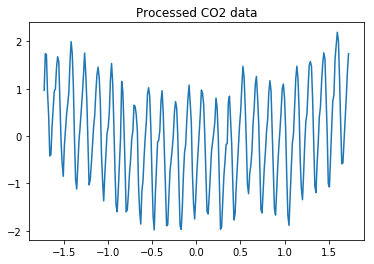

In [3]:
plt.plot(data_train[:, 0], data_train[:, 1]);
plt.title('Processed CO2 data');

We train a standard feedforward network with 5 hidden layers, 1024 units in each layer, ReLU/Tanh non-linearities, and dropout with probability 0.2 after each weight layer. As pointed out by [Gal et al.](https://arxiv.org/abs/1506.02142), similar results can be got when using 4 hidden layers or dropout probability of 0.1.

In [4]:
class MLP2(nn.Module):
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu'):
        super(MLP2, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('input', nn.Linear(1, hidden_layers[0]))
        if activation == 'relu':
            self.model.add_module('relu0', nn.ReLU())
        elif activation == 'tanh':
            self.model.add_module('tanh0', nn.Tanh())
        for i in range(len(hidden_layers)-1):
            self.model.add_module('dropout'+str(i+1), nn.Dropout(p=droprate))
            self.model.add_module('hidden'+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            if activation == 'relu':
                self.model.add_module('relu'+str(i+1), nn.ReLU())
            elif activation == 'tanh':
                self.model.add_module('tanh'+str(i+1), nn.Tanh())
        self.model.add_module('dropout'+str(i+2), nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(hidden_layers[i+1], 1))
        
    def forward(self, x):
        return self.model(x)
    
class MLP2Regressor:
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu', \
                 max_epoch=1000000, lr=0.0001, weight_decay=1e-6):
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = MLP2(hidden_layers=hidden_layers, droprate=droprate, activation=activation)
        self.model.cuda()
        self.criterion = nn.MSELoss().cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        
    def fit(self, X_train, y_train, verbose=True):
        X = Variable(torch.from_numpy(X_train).type(torch.FloatTensor)).cuda()
        y = Variable(torch.from_numpy(y_train).type(torch.FloatTensor)).cuda()
        print(self.model)
        for epoch in range(self.max_epoch):
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, loss.data[0]))
        return self
    
def predict(model, X, T=10000):
    X = Variable(torch.from_numpy(X).type(torch.FloatTensor)).cuda()
    model = model.train()
    Yt_hat = np.array([model(X).data.cpu().numpy() for _ in range(T)]).squeeze()
    model = model.eval()
    y_pred = model(X).data.cpu().numpy()
    model = model.train()
    return y_pred, Yt_hat

In [5]:
mlp2 = MLP2Regressor(activation='relu').fit(X_train, y_train, verbose=True)
torch.save(mlp2.model, 'results/co2_regression_MC_relu_pytorch')

MLP2(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=1024)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.2)
    (hidden1): Linear(in_features=1024, out_features=1024)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.2)
    (hidden2): Linear(in_features=1024, out_features=1024)
    (relu2): ReLU()
    (dropout3): Dropout(p=0.2)
    (hidden3): Linear(in_features=1024, out_features=1024)
    (relu3): ReLU()
    (dropout4): Dropout(p=0.2)
    (hidden4): Linear(in_features=1024, out_features=1024)
    (relu4): ReLU()
    (dropout5): Dropout(p=0.2)
    (final): Linear(in_features=1024, out_features=1)
  )
)


In [6]:
model = torch.load('results/co2_regression_MC_relu_pytorch')
y_pred, y_hat = predict(model, X_test)
y_mc = y_hat.mean(axis=0)
y_mc_std = y_hat.std(axis=0)
IO('results/co2_regression_MC_relu_pytorch_results.pkl').to_pickle((y_pred, y_mc, y_mc_std))

In [7]:
mlp2 = MLP2Regressor(activation='tanh').fit(X_train, y_train, verbose=True)
torch.save(mlp2.model, 'results/co2_regression_MC_tanh_pytorch')

MLP2(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=1024)
    (tanh0): Tanh()
    (dropout1): Dropout(p=0.2)
    (hidden1): Linear(in_features=1024, out_features=1024)
    (tanh1): Tanh()
    (dropout2): Dropout(p=0.2)
    (hidden2): Linear(in_features=1024, out_features=1024)
    (tanh2): Tanh()
    (dropout3): Dropout(p=0.2)
    (hidden3): Linear(in_features=1024, out_features=1024)
    (tanh3): Tanh()
    (dropout4): Dropout(p=0.2)
    (hidden4): Linear(in_features=1024, out_features=1024)
    (tanh4): Tanh()
    (dropout5): Dropout(p=0.2)
    (final): Linear(in_features=1024, out_features=1)
  )
)


In [8]:
model = torch.load('results/co2_regression_MC_tanh_pytorch')
y_pred, y_hat = predict(model, X_test)
y_mc = y_hat.mean(axis=0)
y_mc_std = y_hat.std(axis=0)
IO('results/co2_regression_MC_tanh_pytorch_results.pkl').to_pickle((y_pred, y_mc, y_mc_std))

We can compare the uncertainty we get through dropout with the uncertainty we get from a Gaussian process.

In [ ]:
with pm.Model() as m:
    l = pm.HalfCauchy('l', 0.05)
    eta = pm.HalfCauchy('eta', 1)
    sigma = pm.HalfCauchy('sigma', 0.1)
        
    gp = pm.gp.Marginal(cov_func=(eta ** 2) * pm.gp.cov.ExpQuad(1, l))
    obs = gp.marginal_likelihood('obs', X=X_train, y=y_train.squeeze(), noise=sigma, is_observed=True)

In [ ]:
with m:
    step = pm.NUTS(target_accept=0.95)
    trace1 = pm.sample(5000, tune=2000, step=step, njobs=2)

IO('results/co2_regression_gp.pkl').to_pickle((m, trace1))

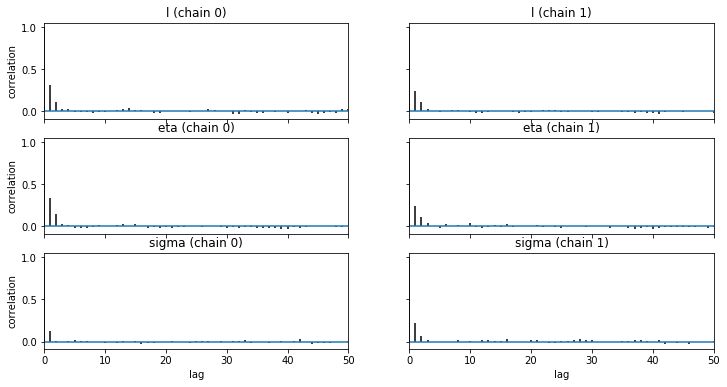

In [5]:
m, trace1 = IO('results/co2_regression_gp.pkl').read_pickle()
pm.autocorrplot(trace1, max_lag=50);

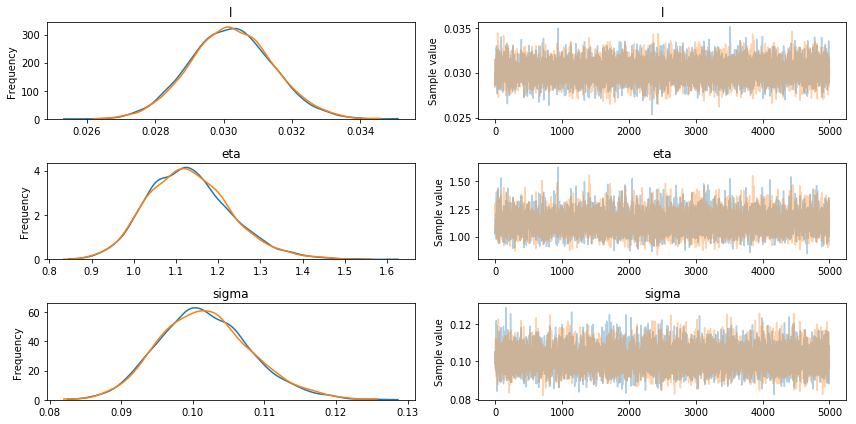

In [6]:
pm.traceplot(trace1);

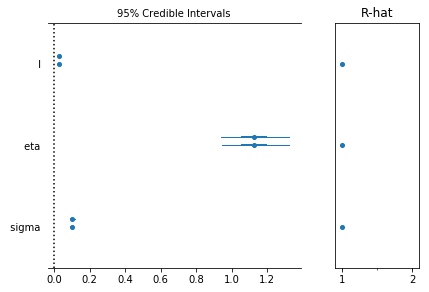

In [7]:
pm.forestplot(trace1);

The above tests show the convergence of the model.

In [ ]:
with m:
    y_gp = gp.conditional('y_pred', Xnew=X_test, pred_noise=True)
    gp_samples = pm.sample_ppc(trace1, vars=[y_gp], samples=10000)
ppc = gp_samples['y_pred']
y_gp_pred = ppc.mean(axis=0)
y_gp_std = ppc.std(axis=0)
IO('results/co2_regression_gp_results.pkl').to_pickle((y_gp_pred, y_gp_std))

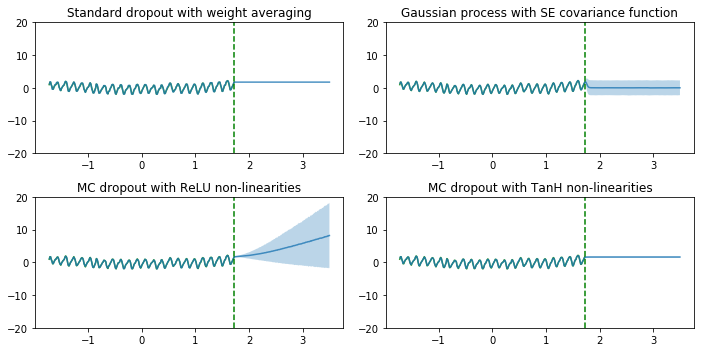

In [5]:
y_relu_pred, y_relu_mc, y_relu_mc_std = IO('results/co2_regression_MC_relu_pytorch_results.pkl').read_pickle()
y_tanh_pred, y_tanh_mc, y_tanh_mc_std = IO('results/co2_regression_MC_tanh_pytorch_results.pkl').read_pickle()
y_gp_pred, y_gp_std = IO('results/co2_regression_gp_results.pkl').read_pickle()

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.title('Standard dropout with weight averaging');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 2)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_gp_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_gp_pred-2*y_gp_std, y_gp_pred+2*y_gp_std, alpha=0.3);
plt.title('Gaussian process with SE covariance function');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 3)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_relu_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_relu_mc-2*y_relu_mc_std, y_relu_mc+2*y_relu_mc_std, alpha=0.3);
plt.title('MC dropout with ReLU non-linearities');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 4)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_tanh_mc-2*y_tanh_mc_std, y_tanh_mc+2*y_tanh_mc_std, alpha=0.3);
plt.title('MC dropout with TanH non-linearities');
plt.ylim([-20, 20]);

plt.tight_layout();

As we can see, the dropout network with ReLU non-linearities and the Gaussian process model successfully show the uncertainty for points away from the training data points. The uncertainty estimates are different since they correpond to different Gaussian process covariance functions. The uncertainty of dropout network with Tanh non-linearities doesn't increase far from the data, presumably because Tanh saturates whereas ReLU does not, as explained by [Gal et al.](https://arxiv.org/abs/1506.02142)